In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import shap
import joblib
from sklearn.model_selection import KFold, train_test_split
from shap_synergy import bootsrap_nsq_syn_list, pvalue0
from xgboost import XGBRegressor
from order_book.df_order_book import order_book

## Fitting XGBoost model

In [42]:
order_book_df = order_book()

df_size = order_book_df.shape[0]

predictors = list(order_book_df.columns)
predictors.remove('prediction-bid-price-yhoo')

target = ['prediction-bid-price-yhoo']

X = order_book_df[predictors]
y = order_book_df[target]

In [6]:
from utils.SequentialGridSearchCV.cv_over_param_dict import cv_over_param_dict
from itertools import product

kfolds = KFold(n_splits=5, shuffle=True)

# initial hyperparameters
current_params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0.1,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'subsample': 0.8,
    'learning_rate': 0.01,
}

##################################################
# round 1: max_depth, min_child_weight
##################################################

max_depths = list(range(2, 12))
min_child_weights = list(range(1, 6))

grid_search_dicts =  [dict(zip(['max_depth', 'min_child_weight'], [a, b])) for a, b in product(max_depths, min_child_weights)]

full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

current_params, results_df = cv_over_param_dict(order_book_df, full_search_dicts, predictors, target, kfolds)

##################################################
# round 2: gamma
##################################################

gammas = np.linspace(0, 1, 11)

grid_search_dicts = [{'gamma': g} for g in gammas]

full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

current_params, results_df = cv_over_param_dict(order_book_df, full_search_dicts, predictors, target, kfolds)

##################################################
# round 3: subsample, colsample_bytree, colsample_bylevel
##################################################

subsamples = np.linspace(0.25, 1, 16)
colsample_bytrees = np.linspace(0.3, 1, 8)
colsample_bylevel = np.linspace(0.3, 1, 8)

grid_search_dicts = [dict(zip(['subsample', 'colsample_bytree', 'colsample_bylevel'], [a, b, c])) for a,b,c in product(subsamples, colsample_bytrees, colsample_bylevel)]

full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

current_params, results_df = cv_over_param_dict(order_book_df, full_search_dicts, predictors, target, kfolds)

##################################################
# round 4: learning_rate
##################################################

learning_rates = np.logspace(-3, 0, 20)

grid_search_dicts = [{'learning_rate': lr} for lr in learning_rates]

full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

current_params, results_df = cv_over_param_dict(order_book_df, full_search_dicts, predictors, target, kfolds)

Start Time           2023-04-06 11:02:56.020153
11:02:56   0 result mean: 1.447547 std: 0.022128, iter: 19.00
11:02:57   1 result mean: 1.447850 std: 0.018222, iter: 19.00
11:02:58   2 result mean: 1.447355 std: 0.012471, iter: 19.00
11:02:59   3 result mean: 1.446823 std: 0.029372, iter: 19.00
11:03:00   4 result mean: 1.447207 std: 0.029501, iter: 19.00
11:03:01   5 result mean: 1.420803 std: 0.024021, iter: 19.00
11:03:02   6 result mean: 1.421852 std: 0.023319, iter: 19.00
11:03:03   7 result mean: 1.422232 std: 0.012228, iter: 19.00
11:03:04   8 result mean: 1.421366 std: 0.022042, iter: 19.00
11:03:05   9 result mean: 1.421080 std: 0.030302, iter: 19.00
11:03:06  10 result mean: 1.402964 std: 0.020012, iter: 19.00
11:03:07  11 result mean: 1.402920 std: 0.030228, iter: 19.00
11:03:08  12 result mean: 1.403635 std: 0.024115, iter: 19.00
11:03:09  13 result mean: 1.403099 std: 0.026739, iter: 19.00
11:03:10  14 result mean: 1.403474 std: 0.014242, iter: 19.00
11:03:11  15 result me

In [7]:
results_df

,rmse,std,best_iter,param_dict
15,0.521682,0.007125,15.4,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
14,0.522193,0.001865,19.0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
16,0.529206,0.002882,9.8,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
17,0.533753,0.007833,5.0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
13,0.536884,0.005392,19.0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
18,0.541290,0.009199,2.4,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
19,0.560090,0.007208,0.6,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
12,0.602734,0.009742,19.0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
11,0.722302,0.011249,19.0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
10,0.876658,0.006023,19.0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."


In [8]:
current_params

{'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0.30000000000000004,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 1.0,
 'subsample': 0.8500000000000001,
 'learning_rate': 0.23357214690901212}

In [50]:
N_ESTIMATORS = 100000
EARLY_STOPPING_ROUNDS = 100

test_size = 100

X_past, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_past, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

params = {
    'max_depth': 7,
    'min_child_weight': 4,
    'colsample_bytree': 1.,
    'colsample_bylevel': 1.,
    'subsample': 0.85,
    'learning_rate': 0.23
    }

my_model = XGBRegressor(
            n_estimators=N_ESTIMATORS,    
            verbosity=1,
            n_jobs=-1,
            booster='gbtree',   
            **params
            ) 

X_train, X_valid, y_train, y_valid = train_test_split(X_past, y_past, test_size=0.2)

my_model.fit(
    X_train, y_train,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    eval_set=[(X_valid, y_valid)],
    verbose=False
    )


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.23, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.85,
             tree_method='exact', validate_parameters=1, verbosity=1)

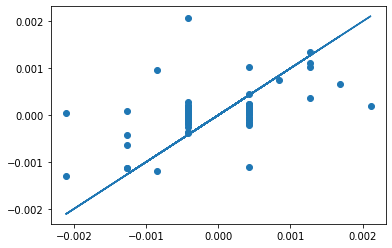

In [47]:
y_pred = my_model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test)
plt.show()

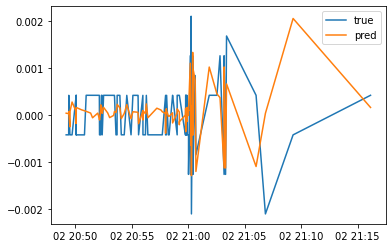

In [48]:
plt.plot(order_book_df.index[-100:], y_test, label='true')
plt.plot(order_book_df.index[-100:], y_pred, label='pred')
plt.legend()
plt.show()

## Compute Shap Values and Shap Interaction Values 

In [49]:
explainer = shap.TreeExplainer(my_model)

shap_values = explainer.shap_values(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [4]:
# save shap values and shap interaction values

joblib.dump({
    'shap_values': shap_values,
    'shap_interaction_values': shap_interaction_values,
    'xgboost_model': my_model,
    'explainer': explainer
    },
    filename='data.joblib',
    compress=2
    )

['data.joblib']

In [10]:
# load shap values and shap interaction values

dump = joblib.load('data.joblib')

shap_values = dump['shap_values']
shap_interaction_values = dump['shap_interaction_values']
my_model = dump['xgboost_model']
explainer = dump['explainer']

## Compute synergies and p-values

### Bootstrap

In [52]:
nb_df = 10
df_size = test_size//nb_df

pvalues_array = np.zeros(shape=(nb_df, 5, 5))

for k in range(nb_df):

    train_nsq_syn_list = bootsrap_nsq_syn_list(shap_values[k*df_size:(k+1)*df_size], shap_interaction_values[k*df_size:(k+1)*df_size], n_samples=10000, sample_size=100)

    pvalues = np.asarray([[pvalue0(train_nsq_syn_list[:, i, j]) for j in range(5)] for i in range(5)])
    for i in range(5):
        pvalues[i, i] = None
    
    pvalues_array[k] = pvalues

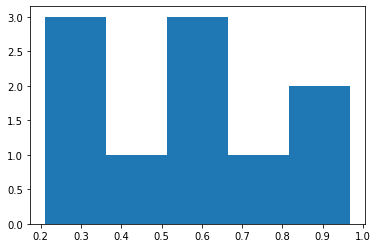

In [54]:
# Plot p-values distribution

plt.hist(pvalues_array[:, 0, 4], cumulative=False, bins='auto')
plt.show()

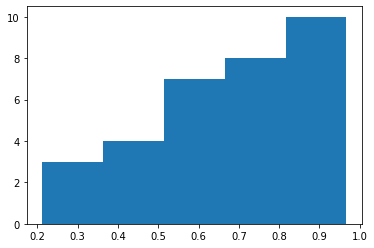

In [55]:
# Plot p-values cdf

plt.hist(pvalues_array[:, 0, 4], cumulative=True, bins='auto')
plt.show()